# Data exploration

## Installing dependencies


In [2]:
import torch
# print(torch.__version__)

OSError: /home/ahmed_b/.conda/envs/electra_cls/lib/python3.11/site-packages/nvidia/cublas/lib/libcublas.so.11: symbol cublasLtGetStatusString version libcublasLt.so.11 not defined in file libcublasLt.so.11 with link time reference

In [12]:
# Attempting to install the old version of Pytorch
!pip install torchvision==0.12.0
!pip install torchaudio==0.11.0
!pip install torchtext==0.12.0
!pip install torch==1.11.0

ERROR: Could not find a version that satisfies the requirement torchvision==0.12.0 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3)
ERROR: No matching distribution found for torchvision==0.12.0
ERROR: Could not find a version that satisfies the requirement torchaudio==0.11.0 (from versions: none)
ERROR: No matching distribution found for torchaudio==0.11.0
ERROR: Could not find a version that satisfies the requirement torchtext==0.12.0 (from versions: 0.1.1, 0.2.0, 0.2.1, 0.2.3, 0.3.1, 0.4.0, 0.5.0, 0.6.0)
ERROR: No matching distribution found for torchtext==0.12.0
ERROR: Could not find a version that satisfies the requirement torch==1.11.0 (from versions: 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==1.11.0


In [13]:
!pip install pytorch-lightning==1.5.10
!pip install transformers==4.17.0
!pip install watermark

In [14]:
print("hello there!")

hello there!


In [15]:
!pip install Markdown==3.3.4

In [16]:
!apt-get install tree

E: Impossible d'ouvrir le fichier verrou /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Impossible d'obtenir le verrou de dpkg (/var/lib/dpkg/lock-frontend). Avez-vous les droits du superutilisateur ?


In [17]:
%reload_ext watermark
%watermark -v -p numpy,pandas,sklearn,torch,pytorch_lightning,transformers

OSError: /home/ahmed_b/.conda/envs/electra_cls/lib/python3.11/site-packages/nvidia/cublas/lib/libcublas.so.11: symbol cublasLtGetStatusString version libcublasLt.so.11 not defined in file libcublasLt.so.11 with link time reference

In [24]:
!pip install seaborn

In [25]:
from typing import Optional
import os

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from torch.utils.data import Dataset, DataLoader
from torch import nn
from transformers import ElectraModel, ElectraPreTrainedModel, ElectraTokenizerFast as ElectraTokenizer, AdamW
from transformers.models.electra.modeling_electra import ElectraClassificationHead

import torch
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

%matplotlib inline 
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette (sns.color_palette (HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(42)

Global seed set to 42


42

## Downloading data from Google Drive

In [26]:
# !wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
# !wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
# !wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

In [27]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Exploring the data

In [ ]:
dataset_drive_path = "/content/drive/MyDrive/Master thesis/Emotion Classification/GoEmotions dataset"
file_paths = list(Path(dataset_drive_path).glob("*.csv"))

dfs = []
for file_path in file_paths:
  dfs.append(pd.read_csv(file_path))
df = pd.concat(dfs)
df.created_utc = pd.to_datetime(df.created_utc, unit='s') # This is not mandatory    
df.head()

In [ ]:
df.shape

In [ ]:
df.groupby("id").head(1).shape

In [ ]:
emotion_categories = df.columns[9:]
emotion_categories

In [ ]:
row = df.iloc[10]
sample_ratings = df[df.id == row.id]
sample_ratings

There are multiple ratings for the same text, corresponding to the different people that are doing the ratings. 

## Tokenizing a sample reddit comment

In [ ]:
sample_ratings.iloc[0].text

In [ ]:
ratings = sample_ratings[emotion_categories]
ratings = ratings.columns[ratings.sum(axis=0) > 0]
ratings = ", ".join(ratings)
ratings

In [ ]:
print(f"text:       {row.text}")
print(f"emotions:   {ratings}")

In [ ]:
from transformers import ElectraTokenizerFast as ElectraTokenizer

MODEL_NAME = "google/electra-base-discriminator"

tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
encoding = tokenizer(row.text)
print(f"Text:      {row.text}")
print(f"Tokens:    {encoding.tokens()}")
print(f"Token IDs: {encoding.input_ids}")

In [ ]:
encoding

## Choosing a good sequence length

In [ ]:
from tqdm import tqdm

token_lens = []

texts = df.groupby("id").head(1).text

for text in tqdm(texts):
  encoding = tokenizer(text)
  token_lens.append(len(encoding.tokens()))

In [ ]:
pd.Series(token_lens).value_counts().sort_index(ascending=False)[:10]

In [ ]:
sns.histplot(token_lens)
plt.xlabel("Token count")

We can see that almost all tokens lengths are less than 64 tokens. Therefore, we can use 64 sequences for the tokenizer to accelerate training. 

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 64])
plt.xlabel("Token count")

# Developing a classifier based on Google ELECTRA

## About the ELECTRA model 

### **Summary**

The pre-training task for popular language models like BERT and XLNet involves masking a small subset of unlabeled input and then training the network to recover this original input. Even though it works quite well, this approach is not particularly data-efficient as it learns from only a small fraction of tokens (typically ~15%). As an alternative, the researchers from Stanford University and Google Brain propose a new pre-training task called replaced token detection. Instead of masking, they suggest replacing some tokens with plausible alternatives generated by a small language model. Then, the pre-trained discriminator is used to predict whether each token is an original or a replacement. As a result, the model learns from all input tokens instead of the small masked fraction, making it much more computationally efficient. The experiments confirm that the introduced approach leads to significantly faster training and higher accuracy on downstream NLP tasks.

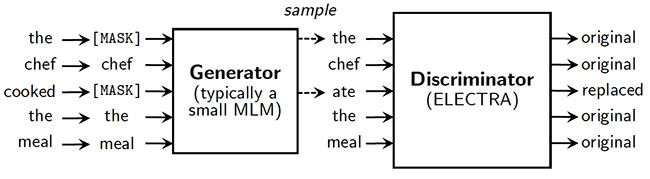

### **What’s the core idea of this paper?**



*   Pre-training methods that are based on masked language modeling are computationally inefficient as they use only a small fraction of tokens for learning.
*   Researchers propose a new pre-training task called replaced token detection, where some tokens are replaced by samples from a small generator network, and a model is pre-trained as a discriminator to distinguish between original and replaced tokens.
*   The introduced approach, called ELECTRA (Efficiently Learning an Encoder that Classifies Token Replacements Accurately): enables the model to learn from all input tokens instead of the small masked-out subset; and is not adversarial, despite the similarity to GAN, as the generator producing tokens for replacement is trained with maximum likelihood.





### **What’s the key achievement?**



*   Demonstrating that the discriminative task of distinguishing between real data and challenging negative samples is more efficient than existing generative methods for language representation learning.

*   Introducing a model that substantially outperforms state-of-the-art approaches while requiring less pre-training compute:
ELECTRA-Small gets a GLUE score of 79.9 and outperforms a comparably small BERT model with a score of 75.1 and a much larger GPT model with a score of 78.8.
An ELECTRA model that performs comparably to XLNet and RoBERTa uses only 25% of their pre-training compute.
ELECTRA-Large outscores the alternative state-of-the-art models on the GLUE and SQuAD benchmarks while still requiring less pre-training compute.


# Building a custom dataset

In [ ]:
df.head()

Since multiple annotators do not necessarily agree on the emotion label, we're going to take the most frequent emotion as the real label: 

In [ ]:
texts = []
emotions = []

for comment_id, group in df.groupby("id"):
  texts.append(group.iloc[0].text)
  emotions.append(group[emotion_categories].sum(axis=0).argmax())

In [ ]:
text_df = pd.DataFrame({"text": texts, "emotion": emotions})
text_df.head()

In [ ]:
EMOJI_MAP = {
    'admiration': '👏',
    'amusement': '😂',
    'anger': '😡',
    'annoyance': '😒',
    'approval': '👍',
    'caring': '🤗',
    'confusion': '😕',
    'curiosity': '🤔',
    'desire': '😍',
    'disappointment': '😞',
    'disapproval': '👎',
    'disgust': '🤮',
    'embarrassment': '😳',
    'excitement': '🤩',
    'fear': '😨',
    'gratitude': '🙏',
    'grief': '😢',
    'joy': '😃',
    'love': '❤️',
    'nervousness': '😬',
    'optimism': '🤞',
    'pride': '😌',
    'realization': '💡',
    'relief': '😅',
    'remorse': '',
    'sadness': '😞',
    'surprise': '😲',
    'neutral': '',
}

In [ ]:
text_df["emoji"] = text_df.emotion.map(lambda x: emotion_categories[x]).map(lambda x: EMOJI_MAP[x])

In [ ]:
text_df.head()

In [ ]:
from numpy import index_exp
class EmotionDataset(Dataset):
  def __init__(self, data: pd.DataFrame, tokenizer: ElectraTokenizer):
    self.data = data
    self.tokenizer = tokenizer
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    encoding = tokenizer(
        row.text,
        max_length=64, 
        truncation=True,
        padding="max_length",
        add_special_tokens=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors="pt"
    )
    
    return {
        "input_ids": encoding["input_ids"].flatten(),
        "attention_mask": encoding["attention_mask"].flatten(),
        "label": torch.tensor(row.emotion)
    }

In [ ]:
ds = EmotionDataset(text_df, tokenizer)
print(len(ds) == len(text_df))

In [ ]:
for item in ds:
  print(item["input_ids"][:10])
  print(item["label"])
  break

In [ ]:
from matplotlib import test
class EmotionDataModule(pl.LightningDataModule):
  def __init__(
      self, data: pd.DataFrame, tokenizer: ElectraTokenizer, batch_size: int
  ):
    self.data = data
    self.tokenizer = tokenizer
    self.batch_size = batch_size

  def setup(self, stage: Optional[str] = None):
    self.train_df, test_df = train_test_split(self.data, test_size=0.2)
    self.val_df, self.test_df = train_test_split(test_df, test_size=0.5)

  def train_dataloader(self):
    return DataLoader(
        dataset=EmotionDataset(self.train_df, self.tokenizer),
        batch_size=self.batch_size,
        num_workers=os.cpu_count(),
        shuffle=True
    )

  def val_dataloader(self):
    return DataLoader(
        dataset=EmotionDataset(self.val_df, self.tokenizer),
        batch_size=self.batch_size,
        num_workers=os.cpu_count(),
        shuffle=False
    )

  def test_dataloader(self):
    return DataLoader(
        dataset=EmotionDataset(self.test_df, self.tokenizer),
        batch_size=self.batch_size,
        num_workers=os.cpu_count(),
        shuffle=False
    )

In [ ]:
data_module = EmotionDataModule(text_df, tokenizer, batch_size=32)
data_module.setup()

In [ ]:
for batch in data_module.train_dataloader():
  print(len(batch))
  print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["label"].shape)
  break

# Google ELECTRA classifier

## About the ELECTRA model 

### **Summary**

The pre-training task for popular language models like BERT and XLNet involves masking a small subset of unlabeled input and then training the network to recover this original input. Even though it works quite well, this approach is not particularly data-efficient as it learns from only a small fraction of tokens (typically ~15%). As an alternative, the researchers from Stanford University and Google Brain propose a new pre-training task called replaced token detection. Instead of masking, they suggest replacing some tokens with plausible alternatives generated by a small language model. Then, the pre-trained discriminator is used to predict whether each token is an original or a replacement. As a result, the model learns from all input tokens instead of the small masked fraction, making it much more computationally efficient. The experiments confirm that the introduced approach leads to significantly faster training and higher accuracy on downstream NLP tasks.

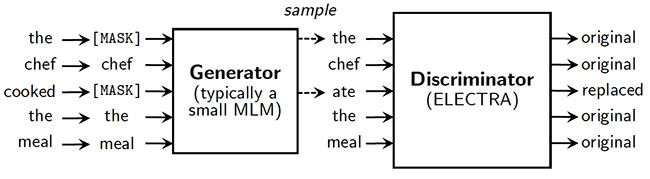

### **What’s the core idea of this paper?**



*   Pre-training methods that are based on masked language modeling are computationally inefficient as they use only a small fraction of tokens for learning.
*   Researchers propose a new pre-training task called replaced token detection, where some tokens are replaced by samples from a small generator network, and a model is pre-trained as a discriminator to distinguish between original and replaced tokens.
*   The introduced approach, called ELECTRA (Efficiently Learning an Encoder that Classifies Token Replacements Accurately): enables the model to learn from all input tokens instead of the small masked-out subset; and is not adversarial, despite the similarity to GAN, as the generator producing tokens for replacement is trained with maximum likelihood.





### **What’s the key achievement?**



*   Demonstrating that the discriminative task of distinguishing between real data and challenging negative samples is more efficient than existing generative methods for language representation learning.

*   Introducing a model that substantially outperforms state-of-the-art approaches while requiring less pre-training compute:
ELECTRA-Small gets a GLUE score of 79.9 and outperforms a comparably small BERT model with a score of 75.1 and a much larger GPT model with a score of 78.8.
An ELECTRA model that performs comparably to XLNet and RoBERTa uses only 25% of their pre-training compute.
ELECTRA-Large outscores the alternative state-of-the-art models on the GLUE and SQuAD benchmarks while still requiring less pre-training compute.


## Pipeline

### Mask prediction

In [ ]:
from transformers import pipeline
import json

fill_mask = pipeline(
    "fill-mask",
    model="google/electra-base-generator",
    tokenizer="google/electra-base-generator",
    top_k=3
)

In [ ]:
sample_text = "The sky is cloudy, it's probably going to [MASK]."

print(json.dumps(fill_mask(sample_text), indent=4))

## Discriminator

The discriminator's task is to get the tokens and decide if each token was replaced or not.

In [ ]:
from transformers import ElectraForPreTraining

model = ElectraForPreTraining.from_pretrained("google/electra-small-discriminator")

In [ ]:
sample_text = "I am happy because I am doing research."

encoding = tokenizer(sample_text, return_tensors="pt")
outputs = model(**encoding)

In [ ]:
encoding

In [ ]:
encoding.tokens()

In [ ]:
outputs

In [ ]:
outputs.logits

In [ ]:
torch.softmax(outputs.logits, dim=-1)

In [ ]:
torch.softmax(outputs.logits, dim=-1).sum()

The sum is 1 so this is basically a probability distribution.

In [ ]:
def show_detections(tokens, logits):
  replaced_token_index = torch.argmax(logits, dim=-1).item() 

  special_tokens = set(tokenizer.special_tokens_map.values())
  
  for i, token in enumerate(tokens):
    if token in special_tokens:
      continue
    elif i == replaced_token_index:
      print(f"{token} -> replaced")
    else:
      print(f"{token} -> original")

In [ ]:
show_detections(encoding.tokens(), outputs.logits)

## Emotion Classifier

In [ ]:
#from transformers.utils.dummy_pt_objects import ElectraPreTrainedModel
class ElectraClassifier(ElectraPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)
    self.n_classes = config.num_labels
    self.config = config
    self.electra = ElectraModel(config)
    self.classifier = ElectraClassificationHead(config)

    self.post_init()

  def forward(
      self,
      input_ids=None,
      attention_mask=None
  ):
    discriminator_hidden_states = self.electra(input_ids, attention_mask)
    sequence_output = discriminator_hidden_states[0]
    logits = self.classifier(sequence_output)
    return logits

In [ ]:
class EmotionClassifier(pl.LightningModule):
  def __init__(self, n_classes, learning_rate: Optional[float]=None):
    super().__init__()
    self.n_classes = n_classes
    self.classifier = ElectraClassifier.from_pretrained(
        "google/electra-small-discriminator",
        num_labels=n_classes
    )
    self.criterion = nn.CrossEntropyLoss()
    self.learning_rate = learning_rate

  def forward(self, input_ids, attention_mask):
    return self.classifier(input_ids, attention_mask)

  def run_step(self, batch, stage):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["label"].long()
    logits = self(input_ids, attention_mask)

    loss = self.criterion(logits, labels)
    self.log(f"{stage}_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

    return loss

  def training_step(self, batch, batch_idx):
    return self.run_step(batch, "train")

  def validation_step(self, batch, batch_idx):
    return self.run_step(batch, "val")

  def test_step(self, batch, batch_idx):
    return self.run_step(batch, "test")

  def configure_optimizers(self):
    return AdamW(self.parameters(), lr=self.learning_rate)

In [ ]:
MAX_LEARNING_RATE = 1e-2
BATCH_SIZE = 512
TRAINING_STEPS = 650

data_module = EmotionDataModule(
    text_df,
    tokenizer,
    batch_size=BATCH_SIZE
)

model = EmotionClassifier(
    n_classes = len(emotion_categories),
    learning_rate = MAX_LEARNING_RATE
)

In [ ]:
trainer = pl.Trainer(gpus=1)

In [ ]:
lr_finder = trainer.tuner.lr_find(model, data_module, max_lr=MAX_LEARNING_RATE)

In [ ]:
lr_finder.results

In [ ]:
!nvidia-smi

In [ ]:
fig = lr_finder.plot(suggest=True)

In [ ]:
new_lr = lr_finder.suggestion()
new_lr

In [ ]:
model.learning_rate = new_lr

In [ ]:
%load_ext tensorboard

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
experiments_dir = "experiments"
#experiments_dir = "/content/drive/MyDrive/Master thesis/Emotion Classification/ELECTRA checkpoints"

model_checkpoint = ModelCheckpoint(
    filename="{epoch}-{step}-{val_loss:.2f}",
    save_last=True,
    save_top_k=3,
    monitor="val_loss_epoch",
    mode="min"
)

logger = TensorBoardLogger(save_dir=experiments_dir, name="emotion_classification")

In [ ]:
%tensorboard --logdir experiments

In [ ]:
trainer = pl.Trainer(
    default_root_dir=experiments_dir,
    gpus=1,
    max_epochs=10,
    # max_steps=TRAINING_STEPS,
    precision=16,
    val_check_interval=40,
    callbacks=[
        model_checkpoint
    ],
    logger=logger
)

In [ ]:
trainer.fit(model, data_module)

In [ ]:
trainer.test(datamodule=data_module)

In [ ]:
model.classifier.save_pretrained("emotion_classifier")

Loading the trained model:

In [ ]:
trained_model = EmotionClassifier.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_classes=len(emotion_categories)
)

In [ ]:
trainer.checkpoint_callback.best_model_score 

In [ ]:
trained_model.eval()

In [ ]:
# trained_model.freeze()

In [ ]:
def Predict_emotion(text, top_k=3):
  encoding = tokenizer(
          text,
          max_length=64, 
          truncation=True,
          padding="max_length",
          add_special_tokens=True,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors="pt"
      )
  # outputs = trained_model(encoding["input_ids"], encoding["attention_mask"])
  outputs = trained_model(**encoding)
  probabilities = list(torch.softmax(outputs, dim=-1).detach().numpy().flatten())
  emotion_idx = torch.argmax(outputs, dim=-1).item() 
  predicted_emotion = emotion_categories[emotion_idx]

  emotion_categories_list = list(emotion_categories)
  probabilities, emotion_categories_list = zip(*sorted(zip(probabilities, emotion_categories_list)))
  probabilities = probabilities[::-1]
  emotion_categories_list = emotion_categories_list[::-1]

  print(f'The sentence "{sample_text}"')
  print(f"Expresses the {predicted_emotion.upper()} emotion ({100*probabilities[0]:.0f}%).")

  print("\n-- Other probabilities: --\n")
  k = 1
  for label, probability in zip(list(emotion_categories_list), list(probabilities)):
    print(f"P({label}) = {100*probability:.2f}%.")
    k += 1
    if k > top_k: 
      break

In [ ]:
sample_text = "This boy doesn't stop talking!"
Predict_emotion(sample_text)